In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(berufsgruppen=True, pos=True, word_features=True)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_bg_pos_wFeatures_4_vecDim100
loading data...
37823 37823 12053 12053 0 0
took:  4.172369003295898


In [3]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features

print(wf_train[0]) # Abgeschlossene
print(pos_train[0]) # ADJA first
print(y_train[0])

[[0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.         1.         0.00033559]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
from tensorflow.keras import *

In [6]:
wf_test = np.reshape(wf_test, (wf_test.shape[0], wf_test.shape[2]))
wf_train = np.reshape(wf_train, (wf_train.shape[0], wf_train.shape[2]))
pos_test = np.reshape(pos_test, (pos_test.shape[0], pos_test.shape[2]))
pos_train = np.reshape(pos_train, (pos_train.shape[0], pos_train.shape[2]))

In [7]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

bg_input = layers.Input(shape=(len(bg_train[0])))
b = layers.Dense(512, activation='relu')(bg_input)
b = layers.Dropout(0.5)(b)
b = layers.Dense(256, activation='relu')(b)

x = layers.concatenate([vw, f, p, b])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
all_model = models.Model(inputs=[vector_window_input, wf_input, pos_input, bg_input], outputs=[out])

all_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

all_model.evaluate(x=[x_test, wf_test, pos_test, bg_test], y=y_test)

batch_size=32
history = all_model.fit([x_train, wf_train, pos_train, bg_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test, pos_test, bg_test], y_test))

2020-08-20 12:40:34 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
12053/12053 [==============================] - 26s 2ms/sample - loss: 2.0945 - acc: 0.0233
Train on 37823 samples, validate on 12053 samples


2020-08-20 12:41:04 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37823/37823 [==============================] - 214s 6ms/sample - loss: 0.7689 - acc: 0.7217 - val_loss: 0.6577 - val_acc: 0.7630
Epoch 2/5
37823/37823 [==============================] - 209s 6ms/sample - loss: 0.5898 - acc: 0.7857 - val_loss: 0.5093 - val_acc: 0.8176
Epoch 3/5
37823/37823 [==============================] - 209s 6ms/sample - loss: 0.4781 - acc: 0.8305 - val_loss: 0.4553 - val_acc: 0.8386
Epoch 4/5
37823/37823 [==============================] - 206s 5ms/sample - loss: 0.4304 - acc: 0.8506 - val_loss: 0.4357 - val_acc: 0.8513
Epoch 5/5
37823/37823 [==============================] - 211s 6ms/sample - loss: 0.4056 - acc: 0.8573 - val_loss: 0.4669 - val_acc: 0.8382


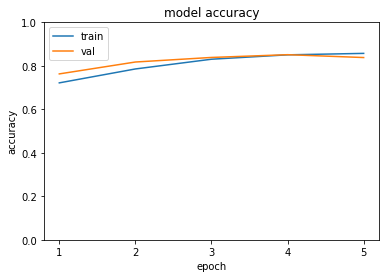

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [9]:
# predict test data
all_y_pred = all_model.predict([x_test, wf_test, pos_test, bg_test])
all_pred_label = prepare_training_data.one_hot_to_labels(all_y_pred)

In [ ]:
import numpy as np
# convert one hot to labels for test data
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [11]:
# Build the model
print('Build model...')
lstm_model = Sequential()
lstm_model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.LSTM(512, return_sequences=True))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.LSTM(256))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.Dense(256))
lstm_model.add(layers.Dense(units=len(labels)))
lstm_model.add(layers.Activation('softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=32
history = lstm_model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

Build model...
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 158s 4ms/sample - loss: 0.8396 - acc: 0.6886 - val_loss: 0.6484 - val_acc: 0.7629
Epoch 2/5
37823/37823 [==============================] - 144s 4ms/sample - loss: 0.5310 - acc: 0.8101 - val_loss: 0.4882 - val_acc: 0.8241
Epoch 3/5
37823/37823 [==============================] - 137s 4ms/sample - loss: 0.4683 - acc: 0.8380 - val_loss: 0.4668 - val_acc: 0.8451
Epoch 4/5
37823/37823 [==============================] - 136s 4ms/sample - loss: 0.4279 - acc: 0.8516 - val_loss: 0.4250 - val_acc: 0.8470
Epoch 5/5
37823/37823 [==============================] - 136s 4ms/sample - loss: 0.3993 - acc: 0.8624 - val_loss: 0.4555 - val_acc: 0.8455


In [12]:

# predict test data
lstm_y_pred = lstm_model.predict([x_test])
lstm_pred_label = prepare_training_data.one_hot_to_labels(lstm_y_pred)

In [19]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

x = layers.concatenate([vw, f])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
wf_model = models.Model(inputs=[vector_window_input, wf_input], outputs=[out])

wf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

wf_model.evaluate(x=[x_test, wf_test], y=y_test)

batch_size=32
history = wf_model.fit([x_train, wf_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test], y_test))


Build model...
12053/12053 [==============================] - 26s 2ms/sample - loss: 2.0737 - acc: 0.0975
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 206s 5ms/sample - loss: 0.8005 - acc: 0.7101 - val_loss: 0.7415 - val_acc: 0.7367
Epoch 2/5
37823/37823 [==============================] - 202s 5ms/sample - loss: 0.5990 - acc: 0.7821 - val_loss: 0.5914 - val_acc: 0.7985
Epoch 3/5
37823/37823 [==============================] - 200s 5ms/sample - loss: 0.4952 - acc: 0.8227 - val_loss: 0.5394 - val_acc: 0.8197
Epoch 4/5
37823/37823 [==============================] - 209s 6ms/sample - loss: 0.4466 - acc: 0.8445 - val_loss: 0.4574 - val_acc: 0.8476
Epoch 5/5
37823/37823 [==============================] - 211s 6ms/sample - loss: 0.4184 - acc: 0.8553 - val_loss: 0.4629 - val_acc: 0.8390


In [20]:
# predict test data
wf_y_pred = wf_model.predict([x_test, wf_test])
wf_pred_label = prepare_training_data.one_hot_to_labels(wf_y_pred)

In [21]:
pred_label = []
for i in range(len(x_test)):
    curr_labels = [lstm_pred_label[i], all_pred_label[i], wf_pred_label[i]]
    if(curr_labels.count(lstm_pred_label[i] >= 2)): pred_label.append(lstm_pred_label[i])
    elif(curr_labels.count(all_pred_label[i] >= 2)): pred_label.append(all_pred_label[i])
    elif(curr_labels.count(wf_pred_label[i] >= 2)): pred_label.append(wf_pred_label[i])
    else: pred_label.append(wf_pred_label[i])

In [22]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.682581 | 0.5      |    0.519337 |     0.646947 |  0.971564 |      0.742038 |    0.699153 |  0.937027 |
| recall    |     0.958333 | 0.203125 |    0.263675 |     0.633645 |  0.927602 |      0.901935 |    0.91922  |  0.898958 |
| f1        |     0.797287 | 0.288889 |    0.349767 |     0.640227 |  0.949074 |      0.814211 |    0.794224 |  0.917598 |
f1 average:  0.6939095950606413
f1 average:  0.6141007888329725
Precision average:  0.7123307910089202
recall average:  0.7133116347633474
acc 0.8393760889405127


In [23]:
wf_prob = wf_model.predict([x_test, wf_test])
lstm_prob = lstm_model.predict_proba([x_test])
all_prob = all_model.predict([x_test, wf_test, pos_test, bg_test])

In [24]:
pred_label2 = []
probabilities = []
for i in range(len(x_test)):
    probs = [0] * len(labels)
    items = [lstm_prob[i], all_prob[i], wf_prob[i]]
    stats = {}
    for net in range(len(items)):
        for index in range(len(items[net])):
            probs[index] += items[net][index]
    pred_label2.append(probs.index(max(probs)))

In [25]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label2, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label2, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label2, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label2, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label2, average=None))/len(list(precision_score(true_label, pred_label2, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label2, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label2, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label2))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.769585 | 0.367347 |    0.602817 |     0.631886 |  0.981221 |      0.777778 |    0.755725 |  0.94144  |
| recall    |     0.907609 | 0.28125  |    0.30014  |     0.707477 |  0.945701 |      0.903226 |    0.91922  |  0.916106 |
| f1        |     0.832918 | 0.318584 |    0.400749 |     0.667549 |  0.963134 |      0.835821 |    0.829493 |  0.9286   |
f1 average:  0.7221058806177479
f1 average:  0.6475188873607266
Precision average:  0.7284748508243106
recall average:  0.7350911072323504
acc 0.8573799054177383
